In [154]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path

proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)

import pandas as pd
import yaml
import torch
import collections

import warnings
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

warnings.filterwarnings("ignore")

from dqn.opinion_dynamics.utils.experiment import process_experiment


In [155]:
# experiment_sub_dir = "2025May02-101004_configs" # excellent run
experiment_sub_dir = "2025May13-230432_configs"

exp_path = os.path.join(r"D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results", experiment_sub_dir)
df = process_experiment(
    exp_path
)
df.columns


Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_optim.args_.lr',
       'sub_exp_cfg_estimator.args_.lin_hidden_out_size',
       'sub_exp_cfg_agent_params.args_.action_w_noise_amplitude',
       'sub_exp_cf

In [156]:
df

,epoch_type,frame_stamp,greedy_epsilon,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,...,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_estimator.args_.lin_hidden_out_size,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_exp_cfg_experiment_run_name,sub_experiment_path,seed,experiment_name
0,training,200000,0.9571,-42.222526,-5.813724,-7.425713,-7.336238,0.706707,-27.547947,-3.864590,...,48749.0,48.0,0 days 00:04:15.056891,1e-06,32,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.lr_1e-06__estimator.args_.lin...
1,training,400000,0.9131,-8.395704,-6.644011,-7.639876,-7.649637,0.223943,-5.448535,-4.168058,...,50000.0,48.0,0 days 00:04:33.207303,1e-06,32,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.lr_1e-06__estimator.args_.lin...
2,training,600000,0.8691,-25.100541,-6.861665,-7.887455,-7.888478,0.274820,-22.092925,-4.160084,...,50000.0,52.0,0 days 00:04:50.603924,1e-06,32,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.lr_1e-06__estimator.args_.lin...
3,training,800000,0.8251,-62.132936,-6.129202,-7.424095,-7.365461,0.800676,-59.608745,-3.992436,...,50000.0,48.0,0 days 00:04:54.190110,1e-06,32,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.lr_1e-06__estimator.args_.lin...
4,training,1000000,0.7811,-10.264032,-6.281694,-7.304735,-7.314108,0.246305,-7.681375,-4.045658,...,50000.0,52.0,0 days 00:04:53.312732,1e-06,32,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.lr_1e-06__estimator.args_.lin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,validation,5200000,NaN,-14.945512,-14.903203,-14.931550,-14.935763,0.011056,-6.199579,-6.190185,...,NaN,NaN,0 days 00:00:00.623130,1e-05,64,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0007_optim.args_.lr_1e-05__estimator.args_.lin...
1436,validation,5400000,NaN,-16.163897,-16.135759,-16.153614,-16.156077,0.007548,-6.276989,-6.271077,...,NaN,NaN,0 days 00:00:00.642111,1e-05,64,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0007_optim.args_.lr_1e-05__estimator.args_.lin...
1437,validation,5600000,NaN,-20.897729,-20.833199,-20.862361,-20.864341,0.019835,-6.925270,-6.915247,...,NaN,NaN,0 days 00:00:00.604015,1e-05,64,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0007_optim.args_.lr_1e-05__estimator.args_.lin...
1438,validation,5800000,NaN,-19.665212,-19.597163,-19.630817,-19.631588,0.018481,-6.776281,-6.766246,...,NaN,NaN,0 days 00:00:00.615526,1e-05,64,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0007_optim.args_.lr_1e-05__estimator.args_.lin...


In [157]:
df[df['epoch_type'] == 'validation']

,epoch_type,frame_stamp,greedy_epsilon,episode_rewards_min,episode_rewards_max,episode_rewards_mean,episode_rewards_median,episode_rewards_std,episode_discounted_rewards_min,episode_discounted_rewards_max,...,policy_trained_times,target_trained_times,epoch_time,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_estimator.args_.lin_hidden_out_size,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_exp_cfg_experiment_run_name,sub_experiment_path,seed,experiment_name
30,validation,200000,NaN,-9.485545,-9.484614,-9.485075,-9.485099,0.000217,-4.942213,-4.941870,...,NaN,NaN,0 days 00:00:00.553918,1e-06,32,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.lr_1e-06__estimator.args_.lin...
31,validation,400000,NaN,-9.493582,-9.492853,-9.493165,-9.493145,0.000158,-4.943737,-4.943480,...,NaN,NaN,0 days 00:00:00.592674,1e-06,32,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.lr_1e-06__estimator.args_.lin...
32,validation,600000,NaN,-9.504806,-9.503887,-9.504406,-9.504442,0.000208,-4.946038,-4.945707,...,NaN,NaN,0 days 00:00:00.573416,1e-06,32,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.lr_1e-06__estimator.args_.lin...
33,validation,800000,NaN,-9.253863,-9.252892,-9.253374,-9.253401,0.000239,-4.901676,-4.901325,...,NaN,NaN,0 days 00:00:00.629169,1e-06,32,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.lr_1e-06__estimator.args_.lin...
34,validation,1000000,NaN,-9.257886,-9.256767,-9.257309,-9.257294,0.000273,-4.902568,-4.902188,...,NaN,NaN,0 days 00:00:00.640770,1e-06,32,0.3,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,0,0000_optim.args_.lr_1e-06__estimator.args_.lin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1435,validation,5200000,NaN,-14.945512,-14.903203,-14.931550,-14.935763,0.011056,-6.199579,-6.190185,...,NaN,NaN,0 days 00:00:00.623130,1e-05,64,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0007_optim.args_.lr_1e-05__estimator.args_.lin...
1436,validation,5400000,NaN,-16.163897,-16.135759,-16.153614,-16.156077,0.007548,-6.276989,-6.271077,...,NaN,NaN,0 days 00:00:00.642111,1e-05,64,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0007_optim.args_.lr_1e-05__estimator.args_.lin...
1437,validation,5600000,NaN,-20.897729,-20.833199,-20.862361,-20.864341,0.019835,-6.925270,-6.915247,...,NaN,NaN,0 days 00:00:00.604015,1e-05,64,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0007_optim.args_.lr_1e-05__estimator.args_.lin...
1438,validation,5800000,NaN,-19.665212,-19.597163,-19.630817,-19.631588,0.018481,-6.776281,-6.766246,...,NaN,NaN,0 days 00:00:00.615526,1e-05,64,0.8,best_params,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,2,0007_optim.args_.lr_1e-05__estimator.args_.lin...


In [158]:
# Define hyperparameter columns
hyperparam_columns = [col for col in df.columns if "sub_exp_cfg" in col]

# Group by hyperparameter values and compute mean episode_rewards_mean
averaged_results = df.groupby(hyperparam_columns, as_index=False).agg({
    'episode_rewards_mean': 'mean',  # Averaging the performance metric
    'sub_experiment_path': 'first'   # Keep a reference to an experiment path
})

# Find the best hyperparameter set based on the highest mean reward
best_row = averaged_results.loc[averaged_results['episode_rewards_mean'].idxmax()]

# Print the best experiment path and hyperparameters
print(f"Best hyperparameters:\n{best_row[hyperparam_columns]}")
print(f"Best mean reward: {best_row['episode_rewards_mean']}")

Best hyperparameters:
sub_exp_cfg_optim.args_.lr                                       1e-06
sub_exp_cfg_estimator.args_.lin_hidden_out_size                     32
sub_exp_cfg_agent_params.args_.action_w_noise_amplitude            0.3
sub_exp_cfg_experiment_run_name                            best_params
Name: 4, dtype: object
Best mean reward: -9.250039407362983


In [159]:
averaged_results

,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_estimator.args_.lin_hidden_out_size,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_exp_cfg_experiment_run_name,episode_rewards_mean,sub_experiment_path
0,1e-05,32,0.3,best_params,-10.628135,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
1,1e-05,32,0.8,best_params,-12.112337,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
2,1e-05,64,0.3,best_params,-11.851356,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
3,1e-05,64,0.8,best_params,-15.693247,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
4,1e-06,32,0.3,best_params,-9.250039,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
5,1e-06,32,0.8,best_params,-10.063624,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
6,1e-06,64,0.3,best_params,-9.296297,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...
7,1e-06,64,0.8,best_params,-10.742922,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...


In [160]:
# selected_metric = 'episode_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"

# # Filter for validation episodes
# validation_df = df[df['epoch_type'] == 'validation']

# # Get the unique sorted frame_stamp values
# unique_frames = np.sort(validation_df['frame_stamp'].unique())
# N = 1
# # Get all frame_stamp values after the first N unique ones
# filtered_frames = unique_frames[N:]

# # Filter the DataFrame to only include rows with these frame_stamp values
# filtered_df = validation_df[validation_df['frame_stamp'].isin(filtered_frames)]

# plt.figure(figsize=(10, 6))
# sns.lineplot(data=filtered_df, x='frame_stamp', y=selected_metric, hue=hue_col)
# plt.ylabel(selected_metric)
# plt.xlabel('Frame Stamp')
# plt.show()

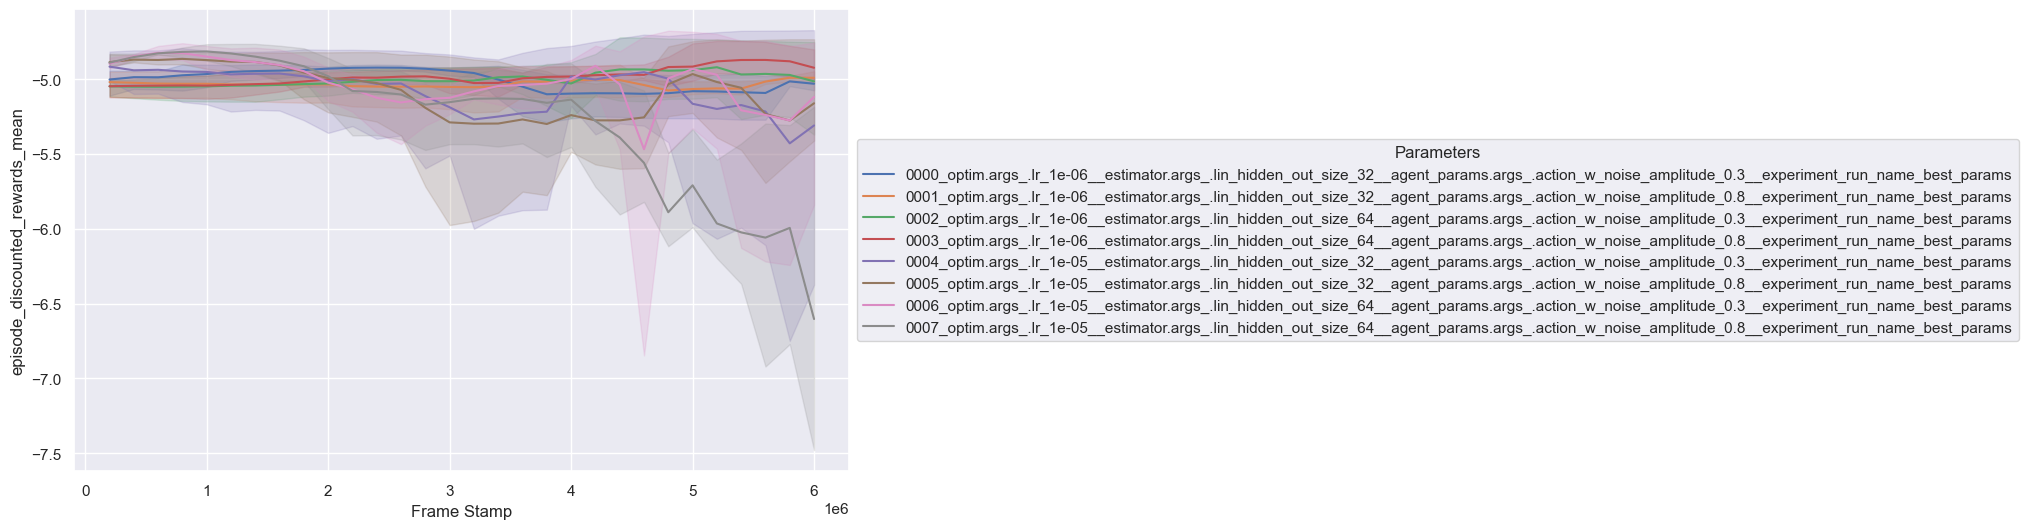

In [161]:

selected_metric = 'episode_discounted_rewards_mean'
# hue_col = "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"
hue_col = "experiment_name"

validation_df = df[df['epoch_type'] == 'validation']


# Create a new figure for each environment
plt.figure(figsize=(10, 6))
# sns.lineplot(data=df, x='frame_stamp', y=selected_metric, hue='model')
sns.lineplot(data=validation_df, x='frame_stamp', y=selected_metric, hue=hue_col)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')

# Place the legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Parameters')
plt.show()

In [162]:
df.columns

Index(['epoch_type', 'frame_stamp', 'greedy_epsilon', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_discounted_rewards_min',
       'episode_discounted_rewards_max', 'episode_discounted_rewards_mean',
       'episode_discounted_rewards_median', 'episode_discounted_rewards_std',
       'episode_frames_min', 'episode_frames_max', 'episode_frames_mean',
       'episode_frames_median', 'episode_frames_std', 'episode_losses_min',
       'episode_losses_max', 'episode_losses_mean', 'episode_losses_median',
       'episode_losses_std', 'episode_max_qs_min', 'episode_max_qs_max',
       'episode_max_qs_mean', 'episode_max_qs_median', 'episode_max_qs_std',
       'policy_trained_times', 'target_trained_times', 'epoch_time',
       'sub_exp_cfg_optim.args_.lr',
       'sub_exp_cfg_estimator.args_.lin_hidden_out_size',
       'sub_exp_cfg_agent_params.args_.action_w_noise_amplitude',
       'sub_exp_cf

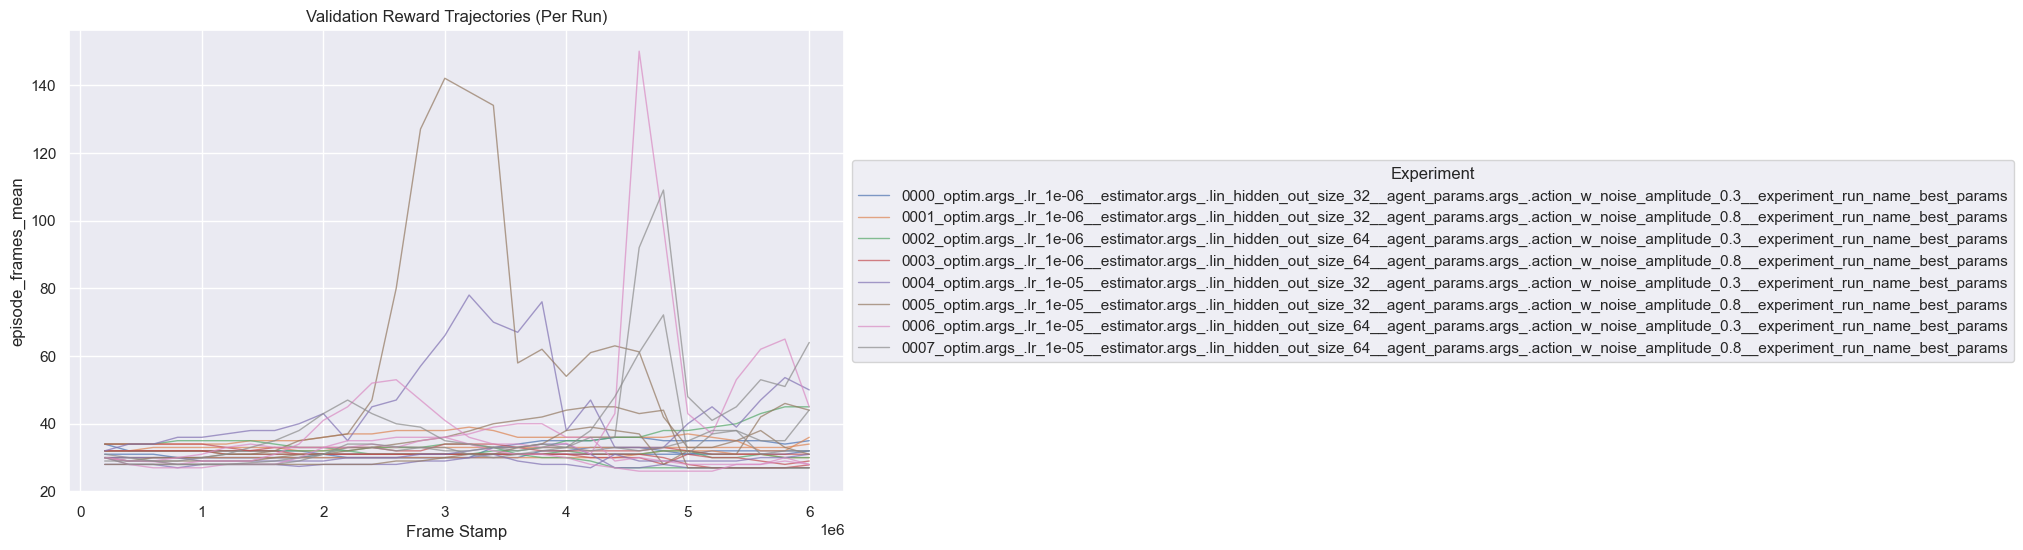

In [163]:
import matplotlib.pyplot as plt
import seaborn as sns

selected_metric = 'episode_frames_mean'
hue_col = "experiment_name"  # or another distinguishing column like "sub_experiment_path"

validation_df = df[df['epoch_type'] == 'validation']

# Plot individual lines for each run
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=validation_df,
    x='frame_stamp',
    y=selected_metric,
    hue=hue_col,
    estimator=None,  # ← disables aggregation
    units='sub_experiment_path',  # ← groups lines by unique run
    lw=1,  # line width
    alpha=0.7  # transparency
)

plt.ylabel(selected_metric)
plt.xlabel('Frame Stamp')
plt.title('Validation Reward Trajectories (Per Run)')

# Move legend outside the plot
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), title='Experiment')
plt.tight_layout()
plt.show()


In [164]:
### Select data

experiment_columns = [
    'epoch_type', 'frame_stamp',
    'episode_rewards_mean', 'episode_frames_mean', 
    'episode_discounted_rewards_mean',
    'policy_trained_times', 'target_trained_times', 'epoch_time', 
       'seed', 'experiment_name', "sub_experiment_path"
]
hyperparam_columns = [
   col for col in df.columns if "sub_exp_cfg" in col
]

cols_of_interest = experiment_columns + hyperparam_columns

sub_df = df[cols_of_interest]
sub_df = sub_df[sub_df['epoch_type'] == 'validation']
sub_df = sub_df[sub_df['frame_stamp'] == sub_df['frame_stamp'].max()]

sub_df 


,epoch_type,frame_stamp,episode_rewards_mean,episode_frames_mean,episode_discounted_rewards_mean,policy_trained_times,target_trained_times,epoch_time,seed,experiment_name,sub_experiment_path,sub_exp_cfg_optim.args_.lr,sub_exp_cfg_estimator.args_.lin_hidden_out_size,sub_exp_cfg_agent_params.args_.action_w_noise_amplitude,sub_exp_cfg_experiment_run_name
59,validation,6000000,-10.489925,35.000000,-5.073668,NaN,NaN,0 days 00:00:00.659774,0,0000_optim.args_.lr_1e-06__estimator.args_.lin...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,32,0.3,best_params
119,validation,6000000,-9.730413,32.000000,-4.991624,NaN,NaN,0 days 00:00:00.647873,1,0000_optim.args_.lr_1e-06__estimator.args_.lin...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,32,0.3,best_params
179,validation,6000000,-9.835991,32.000000,-5.024410,NaN,NaN,0 days 00:00:00.601929,2,0000_optim.args_.lr_1e-06__estimator.args_.lin...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,32,0.3,best_params
239,validation,6000000,-10.113299,34.000000,-5.024252,NaN,NaN,0 days 00:00:00.605183,0,0001_optim.args_.lr_1e-06__estimator.args_.lin...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,32,0.8,best_params
299,validation,6000000,-10.216652,36.000000,-4.999126,NaN,NaN,0 days 00:00:00.623423,1,0001_optim.args_.lr_1e-06__estimator.args_.lin...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,32,0.8,best_params
359,validation,6000000,-9.331827,30.000000,-4.946112,NaN,NaN,0 days 00:00:00.637262,2,0001_optim.args_.lr_1e-06__estimator.args_.lin...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,32,0.8,best_params
419,validation,6000000,-9.321936,30.000000,-4.920355,NaN,NaN,0 days 00:00:00.600226,0,0002_optim.args_.lr_1e-06__estimator.args_.lin...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,64,0.3,best_params
479,validation,6000000,-8.432154,27.000000,-4.751230,NaN,NaN,0 days 00:00:00.608185,1,0002_optim.args_.lr_1e-06__estimator.args_.lin...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,64,0.3,best_params
539,validation,6000000,-12.992009,45.000000,-5.370025,NaN,NaN,0 days 00:00:00.607437,2,0002_optim.args_.lr_1e-06__estimator.args_.lin...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,64,0.3,best_params
599,validation,6000000,-9.376891,29.000000,-5.002856,NaN,NaN,0 days 00:00:00.624204,0,0003_optim.args_.lr_1e-06__estimator.args_.lin...,D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dyna...,1e-06,64,0.8,best_params


In [165]:
# agg_cols = [col for col in sub_df.columns if "sub_exp_cfg_agent_params" in col]
# aggregated_df = (
#     sub_df.groupby(agg_cols)
#     .agg(episode_discounted_rewards_mean=("episode_discounted_rewards_mean", "mean"))
#     .reset_index()
# )
# aggregated_df

In [166]:
sub_df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_mean',
       'episode_frames_mean', 'episode_discounted_rewards_mean',
       'policy_trained_times', 'target_trained_times', 'epoch_time', 'seed',
       'experiment_name', 'sub_experiment_path', 'sub_exp_cfg_optim.args_.lr',
       'sub_exp_cfg_estimator.args_.lin_hidden_out_size',
       'sub_exp_cfg_agent_params.args_.action_w_noise_amplitude',
       'sub_exp_cfg_experiment_run_name'],
      dtype='object')

In [167]:
# sub_df[[
#     "episode_discounted_rewards_mean", "episode_frames_mean",
#     "seed", "sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"]
# ]

In [168]:
# sub_df[
#     (sub_df["sub_exp_cfg_agent_params.args_.action_w_noise_amplitude"] == "0.3") 
# ]

In [169]:
# Print the experiment_name of the row with the highest episode_rewards_mean 
print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['sub_experiment_path'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['experiment_name'].values[0])
# print(sub_df[sub_df['episode_rewards_mean'] == sub_df['episode_rewards_mean'].max()]['episode_rewards_mean'].values[0])


D:\Work\repos\RL\phd-rl-algos\dqn\opinion_dynamics\experiments\results\2025May13-230432_configs\0004_optim.args_.lr_1e-05__estimator.args_.lin_hidden_out_size_32__agent_params.args_.action_w_noise_amplitude_0.3__experiment_run_name_best_params\2


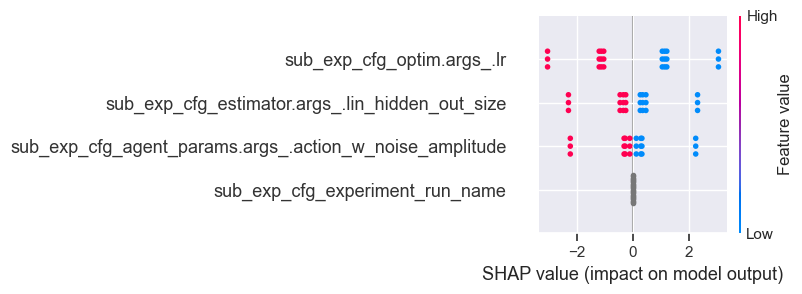

In [170]:
import shap
import xgboost
import pandas as pd


# Define the target metric and hyperparameter columns
target_metric = "episode_rewards_mean"  # Replace with actual metric column name
# Replace with actual hyperparameter column names

# Prepare data
X = sub_df[hyperparam_columns].apply(pd.to_numeric, errors='coerce')
y = sub_df[target_metric].fillna(3 * sub_df[target_metric].min())

# Train an XGBoost model to analyze feature importance
model = xgboost.XGBRegressor(objective="reg:squarederror", n_estimators=100, random_state=42)
model.fit(X, y)

# SHAP analysis
explainer = shap.Explainer(model)
shap_values = explainer(X)

# Summary plot (feature importance)
shap.summary_plot(shap_values, X)

In [171]:
hyperparam_columns

['sub_exp_cfg_optim.args_.lr',
 'sub_exp_cfg_estimator.args_.lin_hidden_out_size',
 'sub_exp_cfg_agent_params.args_.action_w_noise_amplitude',
 'sub_exp_cfg_experiment_run_name']

In [172]:
import plotly.express as px

# Define readable names for selected hyperparams
readable_names = {
    hyperparam_columns[0]: "noise",
    hyperparam_columns[1]: "size"
}

# Rename columns in a copy of the dataframe
plot_df = sub_df.rename(columns=readable_names)

# Assign new column names
x_col = "noise"
y_col = "episode_rewards_mean"
facet_col = "size"

# Plot
fig = px.scatter(
    plot_df,
    x=x_col,
    y=y_col,
    color="experiment_name",  # Optional: color by experiment
    facet_col=facet_col,
    title="Episode Rewards vs. Noise Faceted by Size",
    height=600
)

fig.update_layout(showlegend=False)
fig.show()
